# Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Comics Characters on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Comic Book Characters Network
* Properties of the network structure, including how univere-origin and other properties shape the network

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into [Section 9.4](http://networksciencebook.com/chapter/9#modularity) in the exercises below. We will also talk a little bit about degree correlations - you can read about those in [Chapter 7](http://networksciencebook.com/chapter/7)\.

## The informal intro

Today I talk about the exercises for today. Plain and simple. No additional practical information.

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("[link]",width=800, height=450)

---
# Part A: Let's  visualise!

*Exercise 1*: Build the right graph for visualization. 

We will continue to work with the network from last week, see the lecture for [Week 4](https://nbviewer.jupyter.org/github/socialcomplexitylab/socialgraphs2020/blob/master/lectures/Week4.ipynb) for details. This is important! Actually, in order to continue with the lecture, you *need* to complete Week 4:

>1. Use NetworkX `DiGraph` to store the network of characters. Remember that characters are linked if they have a corresponding link between their Wikipedia contents. 
>   * **Additionally**, extract the largest component - it will make our work with visualisations much easier (note: removing *isolated* nodes (with no links) does not guarantee that you are left with the largest component).
>     - *Note 1*: You probably have the right graph if you have more than 2k nodes and more than 15k edges.
>     - *Note 2*: For directed graphs use `weakly connected component` to extract the largest component.
>     - *Note 3*: Further analysis is done with the largest component
>2. As you build the graph, store the attributes of the nodes (remember the `universe` from the past week). On top of that, let's also store the `length of the content` as one of the attributes of the node (i.e. count the number of *words* you have in each character's page). By storing this information as nodal features, we keep all the relevant data in one place. The safe way to count words without counting symbols is to use `regex`, but simpler methods are OK.

In [203]:
import re
import requests
import pandas as pd
from concurrent import futures 
import networkx as nx
import collections
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import random
from fa2 import ForceAtlas2
import powerlaw

In [152]:
dcUrl = '../files/dc_characters.csv'
marvelUrl = '../files/marvel_characters.csv'
dcNames = pd.read_csv(dcUrl, delimiter='|')
marvelNames = pd.read_csv(marvelUrl, delimiter='|')
dcs = set(dcNames['CharacterName'])
marvels = set(marvelNames['CharacterName'])

In [153]:
DG = nx.DiGraph()

def getNeighbors(text):
    pattern = '\[\[(.*?)\]\]'
    rv = []
    for gp in re.findall(pattern, text):
        if gp in dcs or gp.split('|')[0] in dcs:
            rv.append((gp.split('|')[0], 'DC'))
        elif gp in marvels or gp.split('|')[0] in marvels:
            rv.append((gp.split('|')[0], 'Marvel'))
        
    return rv

def wordCount(text):
    if not text:
        return 0
    pattern = '\w+'
    return len(re.findall(pattern, text))

for name in dcs:
    name = str(name)
    DG.add_node(name, universe="DC")
    try:
        with open('./data/DC/' + name, 'r') as f:
            text = f.read()
            neighbors = getNeighbors(text)
            DG.nodes[name]['contentLen'] = wordCount(text)
            for n in neighbors:
                DG.add_node(n[0], universe=n[1])
                DG.add_edge(name, n[0])
    except FileNotFoundError as e:
        pass

for name in marvels:
    name = str(name)
    DG.add_node(name, universe="Marvel")
    try:
        with open('./data/Marvel/' + name, 'r') as f:
            text = f.read()
            neighbors = getNeighbors(text)
            DG.nodes[name]['contentLen'] = wordCount(text)
            for n in neighbors:
                DG.add_node(n[0], universe=n[1])
                DG.add_edge(name, n[0])
    except FileNotFoundError as e:
        pass

In [217]:
rmNodes = []
for node in DG.nodes:
    if DG.degree[node] == 0:
        rmNodes.append(node)

for node in rmNodes:
    DG.remove_node(node)

In [218]:
largest_cc = max(nx.algorithms.components.weakly_connected_components(DG), key=len)

In [219]:
def createSubGraph(G, largest_wcc):
    # Create a subgraph SG based on a (possibly multigraph) G
    SG = G.__class__()
    SG.add_nodes_from((n, G.nodes[n]) for n in largest_wcc)
    if SG.is_multigraph():
        SG.add_edges_from((n, nbr, key, d)
            for n, nbrs in G.adj.items() if n in largest_wcc
            for nbr, keydict in nbrs.items() if nbr in largest_wcc
            for key, d in keydict.items())
    else:
        SG.add_edges_from((n, nbr, d)
            for n, nbrs in G.adj.items() if n in largest_wcc
            for nbr, d in nbrs.items() if nbr in largest_wcc)
    SG.graph.update(G.graph)
    return SG

In [220]:
subDG = createSubGraph(DG, largest_cc)

*Exercise 2:* Let's build a simple visualization of network
>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in couple of the following exercises
>2. Use the NetworkX command `nx.draw_kamada_kawai` to draw the network resulting undirected. (You can find [background on the algorithm here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Node color should depend on the `universe` attribute (i.e. use different colors for DC and Marvel universe)
>   * Set up your plot so that node-size depends on the node *degree*
>   * **Optional**: Set up you plot so that edge color depends on the `universe` attribute. If an edge connects two nodes from Marvel universe assign `color_a`, if the edge connects two nodes from DC universe assign `color_b`, in case a link connects nodes from disparate universes, cases assign `color_c`. (Here, you get to decide on the colors.)

In [134]:
G = subDG.to_undirected()

In [135]:
colorParm = []
node_sizes = []
degree_dict = {n: d for n, d in G.degree()}
for node in G.nodes():
    if G.nodes[node]['universe'] == "DC":
        colorParm.append("#000000")
    else:
        colorParm.append("#ff0000")
    node_sizes.append(degree_dict[node])

In [ ]:
nx.draw_kamada_kawai(G, node_size=node_sizes, node_color=colorParm)

*Exercise 3:* We can make even better visualisations with `ForceAtlas2` package
>1. The [Force Atlas 2 algorithm](https://github.com/bhargavchippada/forceatlas2) helps calculate more aesthetically pleasing positions for the nodes (see what the result looks like below).
>2.You can install the  package typing `pip install fa2` in the terminal. The [github page](https://github.com/bhargavchippada/forceatlas2) explains how to use the package to get coordinates for each node.
> * Visualize the network using the [Networkx draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and node-coordinates from the force atlas algorithm. As in the previous Exercise:
>   * Node color should depend on the `universe` attribute (i.e. use different colors for DC and Marvel universe)
>   * Node size should depend on the node *degree*
>   * **Optional**: Edge colour should depend on the `universe` attribute. If an edge connects nodes from Marvel universe assign `color_a`, if the edge connects nodes from DC universe assign `color_b`, in other cases assign `color_c`
> * Play with the force atlas algorithm parameters to obtain a visualization you like. It may look similar to the one below (but not necessarily). 
> * Describe the structure you observe. Can you see that the nodes seperate into two separate clusters? Can you see high-degree nodes? In the plot below, the red nodes seem to split into two sub-clusters: What's going on there?

![Network](https://github.com/SocialComplexityLab/socialgraphs2020/blob/master/files/week5_fa2_a.png?raw=true)

In [ ]:
nx.kamada_kawai_layout(G)

In [ ]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=nx.kamada_kawai_layout(G), iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=node_sizes, node_color=colorParm, alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

*Exercise 4*: We continue with a qualitative inspection of the Wikipedia pages, that will help us to intepret our results. We investigate the reasons for links between characters to exist on Wikipedia.

>1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>   * Consider the set of neighbours pointing towards the node found above. 
>   * What is the relation between the characters you identified and his/her network neighbours? (e.g. do they appear in the same comics, are they opponents...). You don't need to come up with a grand theory of comics here, I just want you to think about how links com about.
>   * Repeat the exercise for the largest out-degree node. 
>   * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia
>5. Are there any nodes with high out-degree and with few incoming connections? If yes, open WikiPages of such characters and explain what happens?
>6. Are there any nodes with high in-degree and few outcoming connections? Again, open WikiPages of such characters and explain what happens? 

In [162]:
degree_in_sequence = sorted([(d, n) for n, d in subDG.in_degree()], reverse=True)
degree_out_sequence = sorted([(d, n) for n, d in subDG.out_degree()], reverse=True)

In [163]:
print(degree_in_sequence[0][1], subDG.nodes[degree_in_sequence[0][1]])
print(degree_out_sequence[0][1], subDG.nodes[degree_out_sequence[0][1]])

Spider-Man {'universe': 'Marvel', 'contentLen': 25126}
Beast {'universe': 'Marvel', 'contentLen': 15276}


In [164]:
for key in subDG.predecessors(degree_in_sequence[0][1]):
    print(key, subDG.nodes[key]['universe'])

Clark Kent DC
Ragnarok Marvel
Death Marvel
Famine Marvel
Hulk Marvel
Hercules Marvel
Bash Bashford DC
Dakimh the Enchanter Marvel
Iron Man Marvel
Captain America Marvel
Loki Marvel
Vulture Marvel
Volcana Marvel
Bigelow, Charlie DC
Bombshell Marvel
Black Racer Marvel
Blade Summer DC
Black Orchid (I) DC
Doctor Doom Marvel
Jack B. Quick I DC
Spider-Woman Marvel
Xorn Marvel
Beast Marvel
Sauron Marvel
Kraken Marvel
Doctor Strange Marvel
Bug Marvel
Green Goblin Marvel
Ghost Rider Marvel
Venus Marvel
Silver Surfer Marvel
Living Monolith Marvel
Silvermane Marvel
Titanium Man Marvel
Godzilla Marvel
Black Orchid (II) DC
Cyclops Marvel
Griffin Marvel
Bowman DC
Slapstick Marvel
Black Orchid (III) DC
Outlaw Kid Marvel
Western Kid Marvel
Bulldozer Marvel
Bishop Marvel
Bizarro-Mxyzptlk DC
Beyonder Marvel
Impossible Man Marvel
Bunny Vreeland DC
Jackal Marvel
Deadpool Marvel
Psylocke Marvel
Captain Britain Marvel
Kang the Conqueror Marvel
Blizzard Marvel
Vanisher Marvel
High Evolutionary Marvel
Forbush

In [180]:
for key in subDG.predecessors(degree_out_sequence[0][1]):
    print(key, subDG.nodes[key]['universe'])

From above, we can see the most in degree charactor is Spider-Man, most of its predecessors are also comming from the same universe which is Marvel. 

The most out degree charactor is Beast which is also from Marvel. And it dosen't have any predecessor

In my understanding they the same because one out link at same time is also an in link.

High out few in,

High in few out 

# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

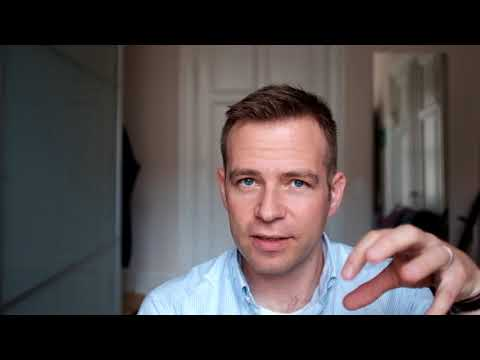

In [117]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 1:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

>1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
>    * On top of that, calculate same statistics separately for the network that is spanned only by DC Characters (we call this the DC-network), and only by the Marvel characters (the Marvel-network). How do you interpret the results? 
>2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install `powerlaw` package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. What does it say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * Some long time ago, couple of scientist have analyzed the network that is spanned by the whole Wikipedia (paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A**? If not, why? 
>3. Plot a scatter plot of the the in- versus out- degree for all characters. Comment on the relation between the two.
>4. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. What is the advantage of using a heatmap over the scatter plot?
>5. Why do you think I want you guys to use a directed graph? Could have we used an undirected graph instead?
>6. We have one more metric that we did not use. The node-attribute `content lenght`. There are two things we can investigate here.
>   * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree.
>   * Secondly, and more interestingly, it could be that longer texts means more famous characters. And that means more in-links. 
>   * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using spearman or pearson, fit a curve to the data, you decide). Once you've tested, let me know. Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words

In [191]:
def statCal(g, d='in'):
    if d == 'in':
        degree_sequence = sorted([d for _, d in g.in_degree()])
    else:
        degree_sequence = sorted([d for _, d in g.out_degree()])
    
    average = sum(degree_sequence) / len(degree_sequence)
    median = degree_sequence[len(degree_sequence)//2]
    mode = sorted([(count, key) for key, count in Counter(degree_sequence).items()], reverse=True)[0][1]
    min_ = min(degree_sequence)
    max_ = max(degree_sequence)
    print("average", average)
    print("median", median)
    print("mode", mode)
    print("minimum", min_)
    print("maximum", max_)    


In [193]:
print("statistics for in degree")
statCal(subDG, 'in')
print("statistics for out degree")
statCal(subDG, 'out')

statistics for in degree
average 7.228116710875332
median 1
mode 0
minimum 0
maximum 472
statistics for out degree
average 7.228116710875332
median 4
mode 0
minimum 0
maximum 73


The average degree value of in and out degree are roughly the same, they have the same mode value and minimum value, however, the maximum value of in degree is larger than the out degree which indicates that usually there will be more citations coming from other pages to one, instead of one refering other pages.

In [194]:
dc_charactors = [node for node in subDG.nodes() if subDG.nodes[node]['universe'] == 'DC']
marvel_charactors = [node for node in subDG.nodes() if subDG.nodes[node]['universe'] == 'Marvel']

In [196]:
dcG = createSubGraph(subDG, dc_charactors)
marvelG = createSubGraph(subDG, marvel_charactors)

In [200]:
print("statistic for DC")
print("statistics for in degree")
statCal(dcG, 'in')
print("statistics for out degree")
statCal(dcG, 'out')

statistic for DC
statistics for in degree
average 6.23773173391494
median 1
mode 0
minimum 0
maximum 216
statistics for out degree
average 6.23773173391494
median 0
mode 0
minimum 0
maximum 59


In [201]:
print("statistic for Marvel")
print("statistics for in degree")
statCal(marvelG, 'in')
print("statistics for out degree")
statCal(marvelG, 'out')

statistic for Marvel
statistics for in degree
average 7.206691449814127
median 0
mode 0
minimum 0
maximum 461
statistics for out degree
average 7.206691449814127
median 5
mode 2
minimum 0
maximum 49


From the statistics, we can see that Marvel average degree are larger then the average degree of DC. Same parttern also can be observed in maximum in-degree and mode value. So one can conclude the charactors in Marvel universe are generally more popular than ones in DC universe.

In [208]:
alpha = powerlaw.Fit([d for _, d in subDG.degree()]).alpha
in_alpha = powerlaw.Fit([d for _, d in subDG.in_degree()]).alpha
out_alpha = powerlaw.Fit([d for _, d in subDG.out_degree()]).alpha

Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [210]:
alpha, in_alpha, out_alpha

(2.917054089569448, 2.4011450279568822, 3.6967468593355592)

From the result we can tell that the network follows the power law

Yes, as concluded from last week, it is a scale-free network

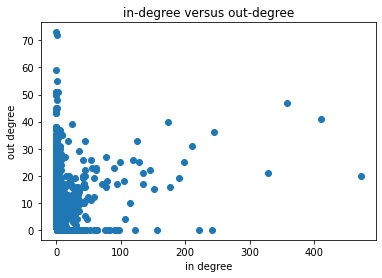

In [235]:
degree_data = [(subDG.in_degree[n], subDG.out_degree[n]) for n in subDG.nodes()]
x, y = [], []
for item in degree_data:
    x.append(item[0])
    y.append(item[1])
plt.scatter(x, y)
plt.title('in-degree versus out-degree')
plt.xlabel("in degree")
plt.ylabel("out degree")
plt.show()

Most charactors have in-degree within 100 and out-degree within 30

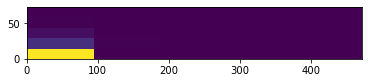

In [245]:
heatmap, xedges, yedges = np.histogram2d(x, y, bins=5)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

The heatmap can show the distribution of the degree more clearly then sccater plot

Because there is a clear direction in this scenario, undirected graph cannot contain the information about which page refers to which one

In [252]:
in_contentLen = [(subDG.nodes[n]['contentLen'], d) for n, d in subDG.in_degree() if 'contentLen' in subDG.nodes[n]]
out_contentLen = [(subDG.nodes[n]['contentLen'], d) for n, d in subDG.out_degree() if 'contentLen' in subDG.nodes[n]]

In [261]:
def plotSeq(data, title, xLabel, yLabel):
    x, y = [], []
    for item in data:
        x.append(item[0])
        y.append(item[1])
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show()

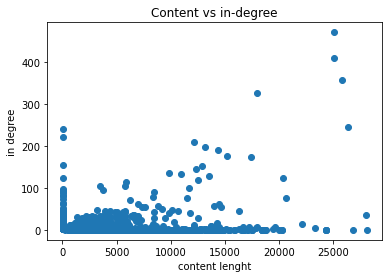

In [262]:
plotSeq(in_contentLen, 'Content vs in-degree', 'content lenght', 'in degree')

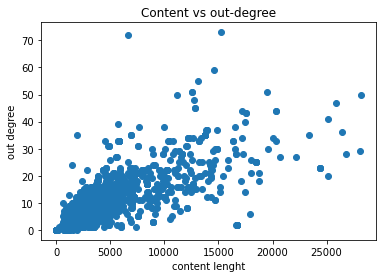

In [263]:
plotSeq(out_contentLen, 'Content vs out-degree', 'content lenght', 'out degree')

Based on the plots above, we can see that the content length has an linear relationship with out-degree, no clear relation shows between the content length and the in-degree

*Exercise 2:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. Meanwhile, **for this exercise use either the DC or Marvel Network alone (i.e. only a single universe). This it will help you to see the differences).**
>1. Find the 5 most central characters according to degree centrality. 
>   * Repeat Exercise A2 or A3 from above for your new sub-network (depending on which visualization method you liked the most), but with our new network.
>1. Find the 5 most central characters according to betweenness centrality. 
>   * Repeat Exercise A2 or A3 (depending on which visualization method you liked the most). However, this time use betweenness centrality to define the size of the node.
>   * What role do you imagine characters with high wikipedia graph betweenness centrality play? 
>2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>   * Repeat Exercise A2 or A3 (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>   * What role do you imagine characters with high wikipedia graph eigenvector centrality play? 
>3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>    * Repeat using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
>4. Is the undirected version of the graph assortative with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
>4. Is the undirected version of the graph assortative with respect do the `content length` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?. Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
>5. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>   * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

---

> * **Optional** (but cool). What about betweenness centrality in the full network? Create a visualization of the network using Force Atlas 2, where you set the size of nodes to scale according to their betweenness centrality. Describe in your own words what you learn from that plot.

*Exercise 3*: Does a universe of a character play a large role? Now, let us explore if and how they shape the network (use full network). 
>1. Compute the average node centrality for Marvel and DC characters respectively (choose your favourite centrality measure). Which universe has the more central characters?
>2. Create a randomized version of the full graph, where the association between nodes and universes is shuffled. Compute the average centrality of DC and Marvel nodes for this randomized graph. 
>   * **Hint**: To create this shuffling, simply give everyone a random universe assignment (but with the same number of Marvel and DC characters as in the real data). The way I usually create random lables is by using either [`random.shuffle`](https://docs.python.org/3/library/random.html#random.shuffle) or [`numpy.random.permutation`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html).
>3. Repeat the shuffling process above 1000 times (at least) and plot two histograms, each histogram with the 1000 corresponding average values of centrality obtained for Marvel and DC characters in the shuffeled netowrks.
>4. Compare the value you have obtained in the real graph, with the randomized cases. Are characters of one of the two universes more central in the network (on average)?
>5. Think about your results, what could be possible explanations for what you observe?